<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Data-Analysis-Projects/blob/master/Predict_Future_Sales_Coursera_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Predicting Future Sales - Coursera Challenge

Performed by
Ken Wood

ROAR Marketing Concepts LLC

ken@roarmarketingconcepts.com


### This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition we work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are being asked to predict total sales for every product and store in the next month. By solving this competition we will be able to apply and enhance our data science skills.

### Mount the Google Drive where the datasets are located...

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### Install some necessary packages to perform the required analysis...

In [2]:
!pip install -U scikit-learn
!pip install --user --upgrade tables
import pandas as pd
import numpy as np
import sklearn
import scipy

import matplotlib.pyplot as plt
from matplotlib import interactive
plt.rc("font", size=14)
from pylab import scatter, show, legend, xlabel, ylabel

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


### Load the datasets..

In [0]:
sales_train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/all/sales_train.csv')
items = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/all/items.csv')
item_categories = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/all/item_categories.csv')
shops = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Predict Future Sales - Coursera Challenge/all/shops.csv')

### Let's look at some properties of the datasets...

In [4]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [9]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### A quick check shows that we have no missing values in any of the datasets...good!!

In [12]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [13]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [14]:
item_categories.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [15]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

### Now we need to merge the datasets on the appropriate keys. 

In [0]:
sales_train = sales_train.merge(items,how='left',on='item_id')
sales_train = sales_train.merge(item_categories, how='left',on = 'item_category_id')
sales_train = sales_train.merge(shops, how='left',on = 'shop_id')

In [17]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### Now that we have merged all the datasets, let's build out the datetime variable.

In [0]:
sales_train['date'] = pd.to_datetime(sales_train['date'],format = '%d.%m.%Y')

sales_train['date_year'] = sales_train['date'].dt.year
sales_train['date_month'] = sales_train['date'].dt.month
month_dict = {1:"Jan",2:"Feb", 3:"Mar", 4:"Apr", 5:"May",6: "Jun", 7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
sales_train['date_month_name'] = sales_train['date_month'].map(month_dict)     # Get month name from month number
sales_train['date_day_of_month'] = sales_train['date'].dt.day
sales_train['date_day_of_week_name'] = sales_train['date'].dt.weekday_name


### We need to insure that the object variables are converted to string variables.

In [0]:
def ConverttoString(column):
  result = sales_train[column].astype(str)
  return result

In [0]:
object_variable_column_headers = ['item_name','item_category_name','shop_name','date_month_name','date_day_of_week_name']
for column_header in object_variable_column_headers:
  ConverttoString(column_header)

In [21]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
date                     datetime64[ns]
date_block_num           int64
shop_id                  int64
item_id                  int64
item_price               float64
item_cnt_day             float64
item_name                object
item_category_id         int64
item_category_name       object
shop_name                object
date_year                int64
date_month               int64
date_month_name          object
date_day_of_month        int64
date_day_of_week_name    object
dtypes: datetime64[ns](1), float64(2), int64(7), object(5)
memory usage: 358.4+ MB


### Calculate the sales for each line item in 'sales_train' by multiplying the quantity sold by the price.

In [0]:
sales_train['sales'] = sales_train['item_cnt_day']*sales_train['item_price']

In [23]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,date_year,date_month,date_month_name,date_day_of_month,date_day_of_week_name,sales
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013,1,Jan,2,Wednesday,999.00
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1,Jan,3,Thursday,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1,Jan,5,Saturday,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1,Jan,6,Sunday,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013,1,Jan,15,Tuesday,1099.00


### Let's look at a few metrics.  First let's look at sales by store per day.

In [24]:
monthly_sales = sales_train.groupby(['date_year','date_month'])['item_id'].count().reset_index()
monthly_sales.sort_values(by=['date_year','date_month'],ascending=True)

,date_year,date_month,item_id
0,2013,1,115690
1,2013,2,108613
2,2013,3,121347
3,2013,4,94109
4,2013,5,91759
5,2013,6,100403
6,2013,7,100548
7,2013,8,104772
8,2013,9,96137
9,2013,10,94202


### How many copies of 'DEEP PURPLE The House Of Blue Light LP' did 'shop_id' = 25 sell in May 2013?

In [25]:
filtered_results = sales_train.loc[sales_train.item_name.str.contains('House Of Blue Light',na=False)]
filtered_results = filtered_results.loc[(filtered_results.date_month == 5) &(filtered_results.date_year == 2013) ]
filtered_results['item_cnt_day'].sum()

0.0

### How many unique items have been sold by 1C?

In [26]:
sales_train['item_id'].nunique()


21807

### What is the sales history by month?

In [0]:
sales_history_by_month = sales_train.groupby(['date_year','date_month'])['sales'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


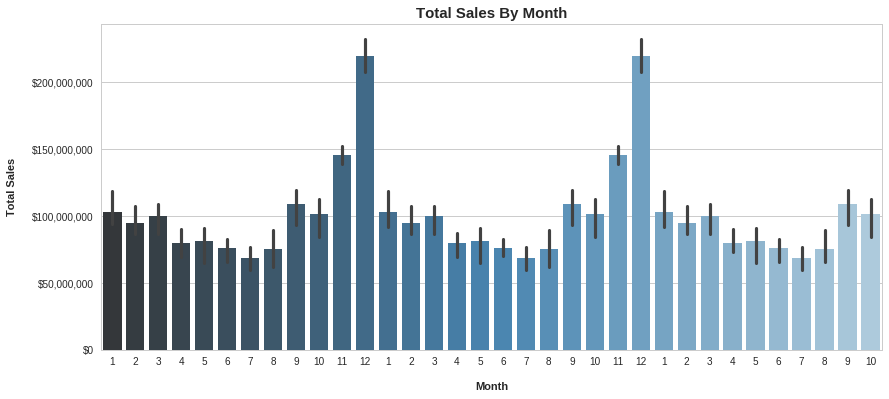

In [40]:
import matplotlib.ticker as mtick

fig,ax = plt.subplots(figsize=(14,6))

order = []                        # Set up order for barchart
for row in sales_history_by_month['date_month']:
  order.append(row)

graph = sns.barplot(x ='date_month',y = 'sales', data = sales_history_by_month, order=order, palette="Blues_d")
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xlabel('Month',fontweight='bold',labelpad=15)
ax.set_ylabel('Total Sales',fontweight='bold',labelpad=15)
ax.set_title('Total Sales By Month',fontsize=15,fontweight='bold')
graph.set_xticklabels(order)

plt.show()